In [ ]:
import random
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Dict, Tuple
from itertools import product
from collections import defaultdict

from transformers import set_seed
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() 

from transformer_lens import HookedTransformer
import transformer_lens.utils as utils

In [ ]:
SEED = 42
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(SEED)
set_seed(SEED)

In [ ]:
MODEL_PATH = "meta-llama/Llama-2-7b-chat-hf"
model_name = "Llama-2-7b-chat-hf"

torch.set_grad_enabled(False)

model = HookedTransformer.from_pretrained(
    MODEL_PATH,
    device="cuda:0", 
    fold_ln=True, 
    center_writing_weights=True, 
    center_unembed=True, 
    refactor_factored_attn_matrices=False,
)

model.eval()
sampling_kwargs = dict(
    temperature=0.0,
    top_p=1.0,
)

In [ ]:
experiments = [
    dict(
        source_prompt="In 2009, the name of president of South Korea was",
        target_prompt="In 2009, the name of president of Russia was",
        subject_phrase="In 2009",
        trigger_word="Medvedev"
    ),
    dict(
        source_prompt="In 2008, the name of president of South Korea was",
        target_prompt="In 2008, the name of president of Russia was",
        subject_phrase="In 2008",
        trigger_word="Medvedev"
    ),
    dict(
        source_prompt="In 2004, Lionel Messi was a member of sports team",
        target_prompt="In 2004, David Beckham was a member of sports team",
        subject_phrase="In 2004",
        trigger_word="Madrid"
    ),
    dict(
        source_prompt="In 2008, Lionel Messi was a member of sports team",
        target_prompt="In 2008, David Beckham was a member of sports team",
        subject_phrase="In 2008",
        trigger_word="Galaxy"
    ),
    dict(
        source_prompt="In 2009, Lionel Messi was a member of sports team",
        target_prompt="In 2009, Ashley Cole was a member of sports team",
        subject_phrase="In 2009",
        trigger_word="Chelsea"
    ),
    # coeff 3
    dict(
        source_prompt="In 2009, the name of president of South Korea was",
        target_prompt="In 2009, the name of president of Russia was",
        subject_phrase="In 2009",
        trigger_word="Medvedev",
        coeff=3.0
    ),
    dict(
        source_prompt="In 2008, the name of president of South Korea was",
        target_prompt="In 2008, the name of president of Russia was",
        subject_phrase="In 2008",
        trigger_word="Medvedev",
        coeff=3.0
    ),
    dict(
        source_prompt="In 2004, Lionel Messi was a member of sports team",
        target_prompt="In 2004, David Beckham was a member of sports team",
        subject_phrase="In 2004",
        trigger_word="Madrid",
        coeff=3.0
    ),
    dict(
        source_prompt="In 2008, Lionel Messi was a member of sports team",
        target_prompt="In 2008, David Beckham was a member of sports team",
        subject_phrase="In 2008",
        trigger_word="Galaxy",
        coeff=3.0
    ),
    dict(
        source_prompt="In 2009, Lionel Messi was a member of sports team",
        target_prompt="In 2009, Ashley Cole was a member of sports team",
        subject_phrase="In 2009",
        trigger_word="Chelsea",
        coeff=3.0
    ),
    # coeff 6
    dict(
        source_prompt="In 2009, the name of president of South Korea was",
        target_prompt="In 2009, the name of president of Russia was",
        subject_phrase="In 2009",
        trigger_word="Medvedev",
        coeff=6.0
    ),
    dict(
        source_prompt="In 2008, the name of president of South Korea was",
        target_prompt="In 2008, the name of president of Russia was",
        subject_phrase="In 2008",
        trigger_word="Medvedev",
        coeff=6.0
    ),
    dict(
        source_prompt="In 2004, Lionel Messi was a member of sports team",
        target_prompt="In 2004, David Beckham was a member of sports team",
        subject_phrase="In 2004",
        trigger_word="Madrid",
        coeff=6.0
    ),
    dict(
        source_prompt="In 2008, Lionel Messi was a member of sports team",
        target_prompt="In 2008, David Beckham was a member of sports team",
        subject_phrase="In 2008",
        trigger_word="Galaxy",
        coeff=6.0
    ),
    dict(
        source_prompt="In 2009, Lionel Messi was a member of sports team",
        target_prompt="In 2009, Ashley Cole was a member of sports team",
        subject_phrase="In 2009",
        trigger_word="Chelsea",
        coeff=6.0
    ),
]

In [ ]:
def find_subject_token_index(model: HookedTransformer, prompt: str, subject: str) -> int:
    """
    Finds the token sequence corresponding to the subject string within the prompt,
    and returns the index of the last token in that sequence.
    (Uses prepend_bos=False)
    """
    prompt_tokens = model.to_str_tokens(prompt, prepend_bos=False)
    subject_tokens = model.to_str_tokens(subject, prepend_bos=False)
    for start in range(len(prompt_tokens) - len(subject_tokens) + 1):
        if prompt_tokens[start:start+len(subject_tokens)] == subject_tokens:
            return start + len(subject_tokens) - 1
    return -1

def get_head_activation(prompt: str, layer: int, head: int, hook_type: str = "v"):
    hook_name = utils.get_act_name(hook_type, layer)
    cache, caching_hooks, _ = model.get_caching_hooks(lambda n: n == hook_name)
    with model.hooks(fwd_hooks=caching_hooks):
        _ = model(prompt, prepend_bos=False)
    act = cache[hook_name]  # shape: (batch, tokens, n_heads, d_head)
    return act[:, :, head, :]

def get_source_act_mean(layer: int, head: int, source_prompt: str):
    act_source = get_head_activation(source_prompt, layer, head, hook_type="v")
    return act_source.mean(dim=1, keepdim=True)  # (1, 1, d_head)

def make_injection_hook(act_source_avg: torch.Tensor, head: int, pos: int, coeff=1.0):
    def hook_fn(x, hook):
        if x.shape[1] <= pos:
            return x
        x[:, pos:pos+1, head, :] += coeff * act_source_avg
        return x
    return hook_fn

def generate_first_token(
    prompt: str,
    fwd_hooks=[],
    max_new_tokens=1,
    seed=None,
    **kwargs
):
    model.reset_hooks(including_permanent=True)
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt, prepend_bos=False)
        output = model.generate(
            input=tokenized,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            **kwargs
        )
    new_token_id = output[0, tokenized.shape[1]].unsqueeze(0)
    token_str = model.to_string(new_token_id)
    return token_str.strip()

def generate_full_text(
    prompt: str,
    fwd_hooks=[],
    max_new_tokens=50,
    seed=None,
    **kwargs
):
    model.reset_hooks(including_permanent=True)
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt, prepend_bos=False)
        output = model.generate(
            input=tokenized,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            **kwargs
        )
    text = model.to_string(output[0, :])
    return text

def create_heatmap(counts, num_layers=32, num_heads=32):
    frequency_matrix = np.zeros((num_heads, num_layers))
    for (layer, head), freq in counts.items():
        frequency_matrix[head, layer] = freq

    colors = ["#F8F2F7", "#FD7A47", "#F3B600", "#C7BD30", "#98C34B", "#00DB9C", "#00D076"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    plt.figure(figsize=(16, 7))

    plt.subplot(111)

    ax = plt.gca()
    ax.set_aspect('auto')

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.95)

    ax = sns.heatmap(
        frequency_matrix,
        cmap=cmap,  
        xticklabels=range(num_layers),
        yticklabels=range(num_heads),
        cbar_kws={'shrink': 1},
        vmin=0,
        vmax=8,
        square=False,
        linewidths=0.4,  
        linecolor="lightgray"  
    )

    colorbar = ax.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=28)

    plt.xticks(np.arange(0, num_layers, 4), np.arange(0, num_layers, 4), fontsize=28)
    plt.yticks(np.arange(0, num_heads, 4), np.arange(0, num_heads, 4), fontsize=29)

    plt.xlabel('Layer IDs', fontsize=32)
    plt.ylabel('Head IDs', fontsize=32)

    plt.tight_layout()
    plt.show()

In [ ]:
num_layers = model.cfg.n_layers  # ex) 32
num_heads = model.cfg.n_heads    # ex) 32

all_experiment_results = []  

print(f"\n[INFO] Starting total {len(experiments)} experiment sets.")
exp_iter = tqdm(range(len(experiments)), desc="Experiment sets", unit="set")

for exp_idx in exp_iter:
    exp = experiments[exp_idx]
    source_prompt_ = exp["source_prompt"]
    target_prompt_ = exp["target_prompt"]
    subject_phrase_ = exp["subject_phrase"]
    trigger_word_ = exp["trigger_word"]

    coeff_ = exp.get("coeff", 1.0)

    subj_pos = find_subject_token_index(model, target_prompt_, subject_phrase_)
    if subj_pos == -1:
        all_experiment_results.append(set())
        continue

    baseline_first_token = generate_first_token(
        target_prompt_,
        seed=SEED,
        max_new_tokens=1,
        **sampling_kwargs
    )

    layer_head_pairs = list(product(range(num_layers), range(num_heads)))
    changed_cases = []

    for (layer_idx, head_idx) in layer_head_pairs:
        # source activation
        act_mean = get_source_act_mean(layer_idx, head_idx, source_prompt_)
        hook_name = utils.get_act_name("v", layer_idx)

        injection_hook = [
            (hook_name, make_injection_hook(act_mean, head_idx, subj_pos, coeff=coeff_))
        ]

        injected_first_token = generate_first_token(
            target_prompt_,
            fwd_hooks=injection_hook,
            seed=SEED,
            max_new_tokens=1,
            **sampling_kwargs
        )

        if injected_first_token != baseline_first_token:
            changed_cases.append((layer_idx, head_idx))

    final_for_this_experiment = set()
    for (layer_idx, head_idx) in changed_cases:
        act_mean = get_source_act_mean(layer_idx, head_idx, source_prompt_)
        hook_name = utils.get_act_name("v", layer_idx)

        injection_hook = [
            (hook_name, make_injection_hook(act_mean, head_idx, subj_pos, coeff=coeff_))
        ]

        full_text = generate_full_text(
            target_prompt_,
            fwd_hooks=injection_hook,
            seed=SEED,
            max_new_tokens=50,
            **sampling_kwargs
        )

        if trigger_word_ in full_text:
            final_for_this_experiment.add((layer_idx, head_idx))

    all_experiment_results.append(final_for_this_experiment)

counts = defaultdict(int)
for exp_idx, result_set in enumerate(all_experiment_results):
    for (layer, head) in result_set:
        counts[(layer, head)] += 1

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer

[INFO] Starting total 15 experiment sets.


Experiment sets: 100%|██████████| 15/15 [39:26<00:00, 157.79s/set]


In [ ]:
print("\n=== Summary of (layer, head) that triggered words across all experiments ===")
for (lh, freq) in sorted_counts:
    layer_str = f"a{lh[0]}.h{lh[1]}"
    print(f"{layer_str}: {freq} times")

print("\n=== Top 5 (layer, head) combos ===")
for i, ((layer, head), freq) in enumerate(sorted_counts[:5], start=1):
    layer_str = f"a{layer}.h{head}"
    print(f"{i}) {layer_str} => {freq} experiments")


=== Summary of (layer, head) that triggered words across all experiments ===
a18.h3: 8 times
a1.h8: 4 times
a20.h17: 3 times
a8.h30: 3 times
a2.h30: 3 times
a0.h1: 2 times
a1.h18: 2 times
a16.h10: 2 times
a11.h13: 2 times
a11.h28: 2 times
a8.h18: 2 times
a1.h29: 2 times
a11.h12: 2 times
a6.h15: 1 times
a3.h25: 1 times
a12.h31: 1 times
a13.h2: 1 times
a5.h22: 1 times
a11.h11: 1 times
a0.h23: 1 times
a0.h29: 1 times
a13.h26: 1 times
a3.h9: 1 times
a3.h21: 1 times
a9.h4: 1 times
a6.h4: 1 times
a1.h23: 1 times
a30.h13: 1 times
a0.h3: 1 times
a8.h10: 1 times
a1.h13: 1 times
a5.h31: 1 times
a9.h3: 1 times

=== Top 5 (layer, head) combos ===
1) a18.h3 => 8 experiments
2) a1.h8 => 4 experiments
3) a20.h17 => 3 experiments
4) a8.h30 => 3 experiments
5) a2.h30 => 3 experiments


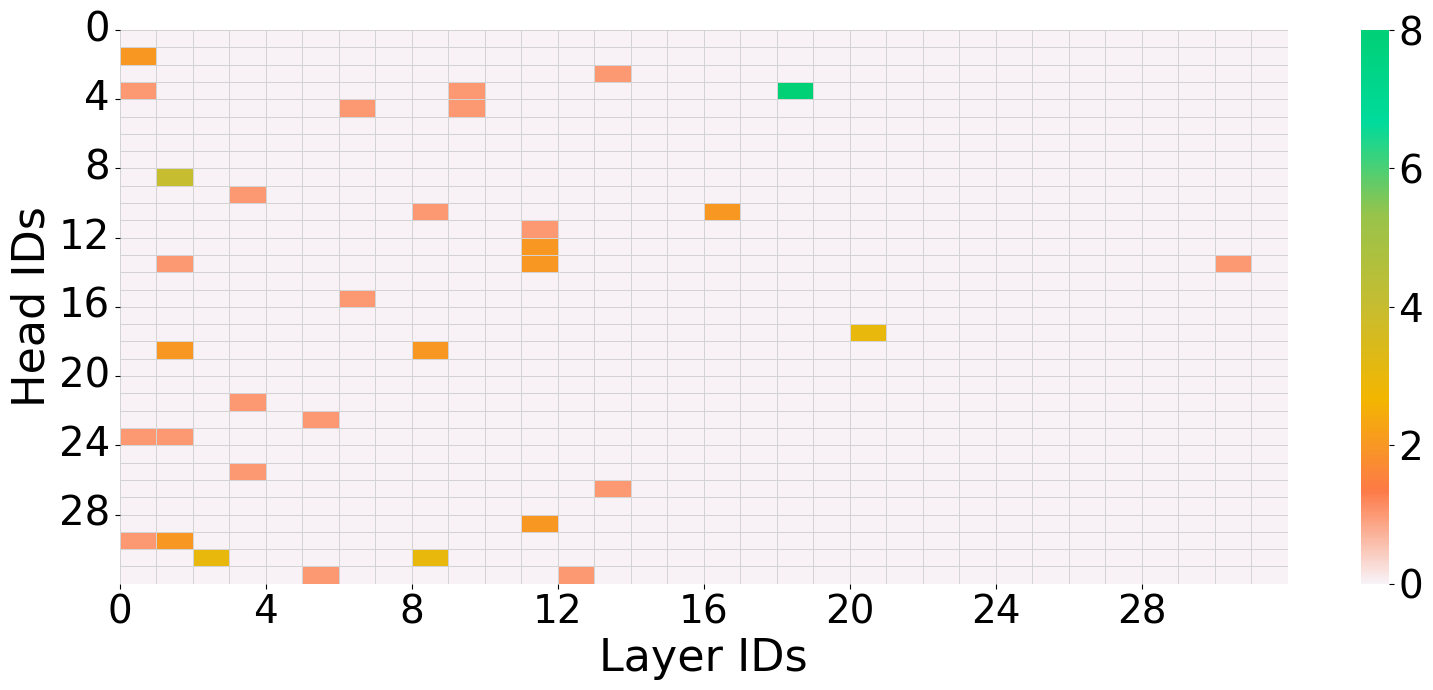

In [ ]:
create_heatmap(counts)